### 1、导入所需的库

In [2]:
#基础
import numpy as np
import pandas as pd
import time

#绘图
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#模型
from sklearn.linear_model import Lasso, LassoCV, ElasticNet, ElasticNetCV, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.svm import SVR
#import lightgbm as lgb
#import xgboost as xgb

#模型相关
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

### 2、读取数据集，对正偏斜的目标值取对数处理

In [3]:
train_data = pd.read_csv('./data/train_data.csv')
test_data = pd.read_csv('./data/test_data.csv')
print('The shape of training data:', train_data.shape)
print('The shape of testing data:', test_data.shape)

The shape of training data: (1454, 151)
The shape of testing data: (1459, 150)


In [4]:
train_data.isnull().sum().any()

False

Skewness of target: 1.8937001627350096
kurtosis of target: 6.607117050051702


((array([-3.30398548, -3.04669486, -2.90360817, ...,  2.90360817,
          3.04669486,  3.30398548]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000])),
 (74054.9258446418, 180658.35350756536, 0.9314322819352355))

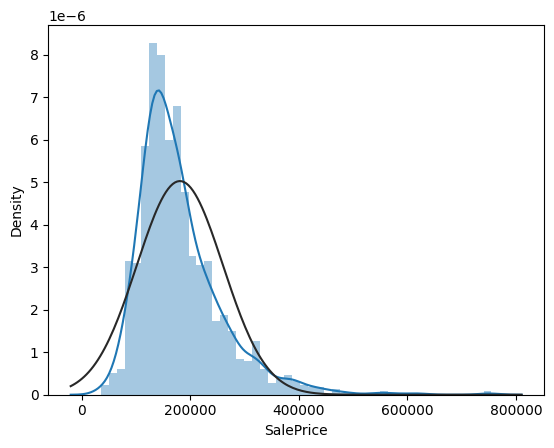

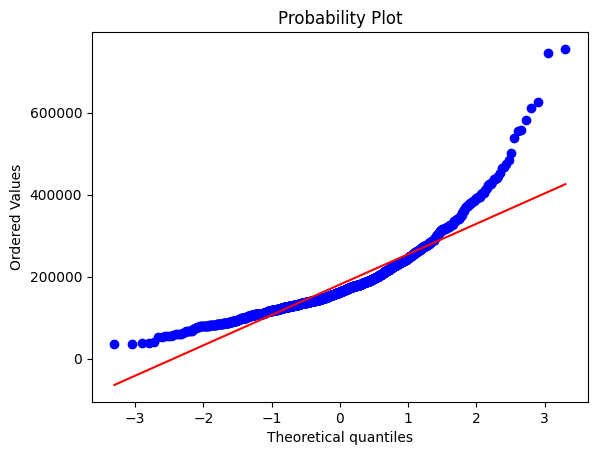

In [6]:
from scipy.stats import skew, kurtosis, norm, probplot

y = train_data['SalePrice']
print('Skewness of target:', y.skew())
print('kurtosis of target:', y.kurtosis())
sns.distplot(y, fit=norm)

# 绘制QQ-plot图
plt.figure()
probplot(y, plot=plt)

可以看出，未处理的目标值明显右偏，不满足正态分布

Skewness of target: 0.1246248046831642
kurtosis of target: 0.8196920161191237


((array([-3.30398548, -3.04669486, -2.90360817, ...,  2.90360817,
          3.04669486,  3.30398548]),
  array([10.46027076, 10.47197813, 10.54273278, ..., 13.34550853,
         13.52114084, 13.53447435])),
 (0.3980491749879913, 12.022633890092896, 0.9952999042750994))

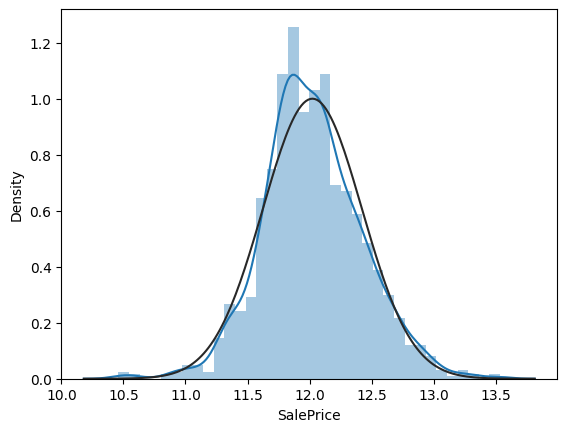

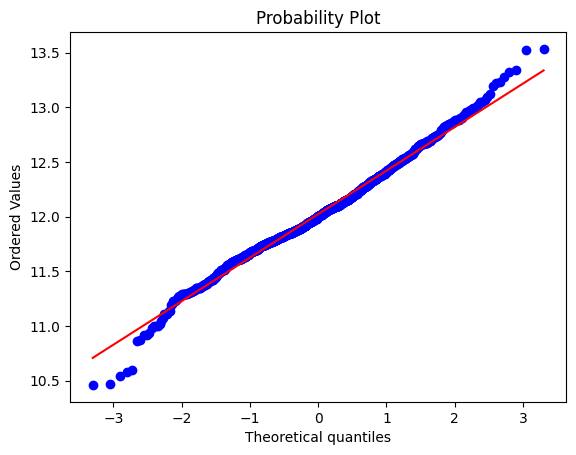

In [7]:
y = np.log1p(y)
print('Skewness of target:', y.skew())
print('kurtosis of target:', y.kurtosis())
sns.distplot(y, fit=norm)

# 绘制QQ-plot图
plt.figure()
probplot(y, plot=plt)

处理后的目标值接近正态分布

### 3、对训练数据集的数字特征添加随机高斯噪声，缓解过拟合问题

In [8]:
import hashlib
import sys
import os
import tarfile
import zipfile
import requests

import tensorflow as tf
from d2l import tensorflow as d2l

In [9]:
def add_gaussian_noise(df, features, mu=0, sigma=0.01, random_seed=None):
    noisy_df = df.copy()
    
    if random_seed:
        np.random.seed(random_seed)
    
    for col in features:
        if col in noisy_df.columns:
            noise = np.random.normal(mu, df[col].std() * sigma, noisy_df[col].shape)
            noisy_df[col] = noisy_df[col] + noise
            
    return noisy_df

In [10]:
float_features = train_data.dtypes[train_data.dtypes == 'float'].index
print(float_features)

noisy_train_data = add_gaussian_noise(
    train_data, 
    features=float_features, 
    mu=0, 
    sigma=0.1,  # 噪声强度设为原始数据标准差的5%
    random_seed=41
)

noisy_train_data.head()

(noisy_train_data['MSSubClass'] - train_data['MSSubClass']).describe()

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
       'KitchenAbvGr', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'TotalSF'],
      dtype='object')


count    1454.000000
mean       -0.003631
std         0.152782
min        -0.507557
25%        -0.106015
50%         0.001897
75%         0.099781
max         0.450004
Name: MSSubClass, dtype: float64

### 4、定义模型

In [11]:
def get_net():
    net = tf.keras.models.Sequential()
    net.add(tf.keras.layers.Dense(
        1,
        #activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))
    #net.add(tf.keras.layers.Dense(1))
    return net

In [12]:
def log_rmse(y_true, y_pred):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = tf.clip_by_value(y_pred, 1, float('inf'))
    return tf.sqrt(tf.reduce_mean(loss(
        tf.math.log(y_true), tf.math.log(clipped_preds))))

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    net.compile(loss=loss, optimizer=optimizer)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                y_hat = net(X)
                l = loss(y, y_hat) + net.losses
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            optimizer.apply_gradients(zip(grads, params))
        train_ls.append(log_rmse(train_labels, net(train_features)))
        if test_labels is not None:
            test_ls.append(log_rmse(test_labels, net(test_features)))
        #print(f'epoch:{epoch}, 训练log rmse：{float(train_ls[-1]):f}, '
        #      f'验证log rmse：{float(test_ls[-1]):f}')
    
    #print(f'{tf.concat([train_labels, net(train_features), train_labels - net(train_features)], 1)}')
    return train_ls, test_ls

**样本数量不多，采用K折验证**

In [14]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part  # 这次训练的验证集
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = tf.concat([X_train, X_part], 0)
            y_train = tf.concat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0.0, 0.0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        #train_l_sum += train_ls[-1]  # 取每次训练最后一轮的结果
        #valid_l_sum += valid_ls[-1]
        train_l_sum += np.mean(train_ls[-10:]) # 取最后10次训练的均值
        valid_l_sum += np.mean(valid_ls[-10:])
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'])#, yscale='log')  # 绘制第一次训练的结果
        print(f'第{i + 1}次训练，训练log rmse：{float(train_ls[-1]):f}, '
              f'验证log rmse：{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

(2913, 149)
(1454, 149)
(1459, 149)
第1次训练，训练log rmse：0.008731, 验证log rmse：0.009621
第2次训练，训练log rmse：0.008881, 验证log rmse：0.010223
第3次训练，训练log rmse：0.008597, 验证log rmse：0.010532
第4次训练，训练log rmse：0.008652, 验证log rmse：0.009819
第5次训练，训练log rmse：0.008711, 验证log rmse：0.009819
平均训练log rmse: 0.008813, 平均验证log rmse: 0.010040


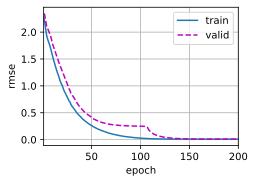

In [15]:
loss = tf.keras.losses.MeanSquaredError()

y = train_data['SalePrice']
#print(train_data['SalePrice'].shape)
y = np.log1p(y)
#y = np.expm1(y)
#print(y.shape)
#print(np.concatenate((train_data['SalePrice'].values.reshape(-1, 1), y.values.reshape(-1, 1), np.expm1(y).values.reshape(-1, 1)), axis=1))
#print(train_data['SalePrice'].values.reshape(-1, 1) - np.expm1(y).values.reshape(-1, 1))

all_features = pd.concat((noisy_train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
#all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.shape)
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)
#print(all_features.shape)
#all_features = pd.get_dummies(all_features, dummy_na=True)
#print(all_features.shape)

n_train = train_data.shape[0]
train_features = tf.constant(all_features[:n_train].values, dtype=tf.float32)
print(train_features.shape)
test_features = tf.constant(all_features[n_train:].values, dtype=tf.float32)
print(test_features.shape)
train_labels = tf.constant(
    y.values.reshape(-1, 1), dtype=tf.float32)
#print(all_features.head())

loss = tf.keras.losses.MeanSquaredError()

k, epochs, learning_rate, weight_decay, batch_size = 5, 200, 0.05, 0.05, 256
train_l, valid_l = k_fold(k, train_features, train_labels, epochs, learning_rate, weight_decay, batch_size)
print(f'平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

### 5、选择最佳参数组合

**生成待验证的参数组合**

In [16]:
# 排列组合
def expand(mulcoldf, sigcoldf):
    r = pd.DataFrame(columns=np.append(mulcoldf.columns.values, sigcoldf.columns.values))
    for x in sigcoldf.values:
        s = mulcoldf.copy()
        s[sigcoldf.columns[0]] = x[0]
        r = pd.concat([r,s])
    return r


# k,epochs,learning_rate,weight_decay,batch_size
def get_params(k=[5], epochs=[100], learning_rate=[0.005, 0.5], weight_decay=[0], batch_size=[64]):
    p = pd.DataFrame()
    p = expand(pd.DataFrame({'k':k}), pd.DataFrame({'epochs':epochs}))
    p = expand(p, pd.DataFrame({'learning_rate':learning_rate}))
    p = expand(p, pd.DataFrame({'weight_decay':weight_decay}))
    p = expand(p, pd.DataFrame({'batch_size':batch_size}))
    return p.reset_index(drop=True)

In [17]:
params = get_params(epochs=[200, 400, 600], 
                    learning_rate=[0.005, 0.05, 0.5, 1, 2, 3, 4, 5], 
                    weight_decay=[0.0005, 0.05, 0.5, 0], 
                    batch_size=[64, 128, 256])
params[-20:]

,k,epochs,learning_rate,weight_decay,batch_size
268,5,400,0.05,0.0,256
269,5,600,0.05,0.0,256
270,5,200,0.50,0.0,256
271,5,400,0.50,0.0,256
272,5,600,0.50,0.0,256
273,5,200,1.00,0.0,256
274,5,400,1.00,0.0,256
275,5,600,1.00,0.0,256
276,5,200,2.00,0.0,256
277,5,400,2.00,0.0,256


======================================== 1 ========================================
k-fold=5,epochs=200,learning_rate=0.005000,weight_decay=0.000500,batch_size=64
第1次训练，训练log rmse：0.042027, 验证log rmse：0.254123
第2次训练，训练log rmse：0.043206, 验证log rmse：0.215733
第3次训练，训练log rmse：0.045453, 验证log rmse：0.260986
第4次训练，训练log rmse：0.053138, 验证log rmse：0.173925
第5次训练，训练log rmse：0.038387, 验证log rmse：0.336907
平均训练log rmse: 0.050490, 平均验证log rmse: 0.251284
======================================== 2 ========================================
k-fold=5,epochs=400,learning_rate=0.005000,weight_decay=0.000500,batch_size=64
第1次训练，训练log rmse：0.008799, 验证log rmse：0.248145
第2次训练，训练log rmse：0.008668, 验证log rmse：0.205987
第3次训练，训练log rmse：0.008585, 验证log rmse：0.251633
第4次训练，训练log rmse：0.008782, 验证log rmse：0.145446
第5次训练，训练log rmse：0.008992, 验证log rmse：0.328763
平均训练log rmse: 0.008859, 平均验证log rmse: 0.236001
======================================== 3 ========================================
k-fold=5,epochs=600,learni

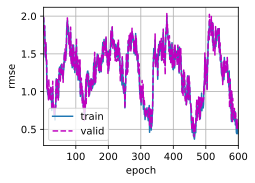

In [18]:
#params = params[:5]

dfrult = pd.DataFrame(columns=('k', 'epochs', 'learning_rate', 'weight_decay', 'batch_size', 'train_avg_loss', 'test_avg_loss'))

for (idx, param) in enumerate(params.values):
    print("%s %d %s" % ("="*40, idx + 1, "="*40))
    
    k, epochs, learning_rate, weight_decay, batch_size = param.tolist()    
    print("k-fold=%d,epochs=%d,learning_rate=%f,weight_decay=%f,batch_size=%d" % (k,epochs,learning_rate,weight_decay,batch_size))

    train_avg_loss, test_avg_loss = k_fold(k, train_features, train_labels, epochs, learning_rate, weight_decay, batch_size)
    print(f'平均训练log rmse: {float(train_avg_loss):f}, '
          f'平均验证log rmse: {float(test_avg_loss):f}')

    temp = pd.DataFrame([[k, epochs, learning_rate, weight_decay, batch_size, train_avg_loss, test_avg_loss]],
                columns=['k', 'epochs', 'learning_rate', 'weight_decay', 'batch_size', 'train_avg_loss', 'test_avg_loss'])
    dfrult = pd.concat([dfrult, temp])

In [19]:
df = dfrult.copy()
df[:5]

,k,epochs,learning_rate,weight_decay,batch_size,train_avg_loss,test_avg_loss
0,5,200,0.005,0.0005,64,0.050490,0.251284
0,5,400,0.005,0.0005,64,0.008859,0.236001
0,5,600,0.005,0.0005,64,0.009753,0.235856
0,5,200,0.050,0.0005,64,0.046955,0.239364
0,5,400,0.050,0.0005,64,0.039309,0.036621


In [20]:
df['diff'] = df['test_avg_loss'] - df['train_avg_loss']
df['sum'] = df['test_avg_loss'] + df['train_avg_loss']
df = df.sort_values('sum').reset_index(drop=True)
df[:5]

,k,epochs,learning_rate,weight_decay,batch_size,train_avg_loss,test_avg_loss,diff,sum
0,5,200,0.050,0.05,256,0.008622,0.010019,0.001397,0.018642
1,5,600,0.005,0.05,128,0.008661,0.010163,0.001502,0.018824
2,5,400,0.005,0.05,64,0.008915,0.010169,0.001254,0.019084
3,5,200,0.050,0.50,256,0.009560,0.010492,0.000932,0.020052
4,5,600,0.005,0.50,128,0.009615,0.010496,0.000881,0.020111


### 6、采用最佳参数，基于所有训练数据，重新训练模型

In [21]:
k, epochs, learning_rate, weight_decay, batch_size = df.iloc[0][0:5]
print("k-fold=%d,epochs=%d,learning_rate=%f,weight_decay=%f,batch_size=%d" % (k, epochs, learning_rate, weight_decay, batch_size))

k-fold=5,epochs=200,learning_rate=0.050000,weight_decay=0.050000,batch_size=256


训练log rmse：0.008931, 验证log rmse：0.008931


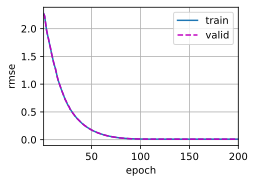

In [22]:
net = get_net()

train_ls, valid_ls = train(net, train_features, train_labels, train_features, train_labels, 
                           epochs, learning_rate, weight_decay, batch_size)

d2l.plot(list(range(1, epochs + 1)), [train_ls, valid_ls], 
         xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs], 
         legend=['train', 'valid'])#, yscale='log')
print(f'训练log rmse：{float(train_ls[-1]):f}, '
      f'验证log rmse：{float(valid_ls[-1]):f}')

### 7、采用测试数据进行推测

In [23]:
preds = net(test_features).numpy()
preds = np.expm1(preds)

# 将其重新格式化以导出到Kaggle
test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
test_data['Id'] = test_data.reset_index(drop = True).index + 1461
submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
submission.to_csv('./data/submission.csv', index=False)